In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from typing import *

from typet5.utils import proj_root, get_data_dir

os.chdir(proj_root())

datadir = get_data_dir()
repos_dir = datadir / "SPOT-data/repos"

In [2]:
load_trained = False

if load_trained:
    model_path = datadir / "checkpoints/saved/SPOT-with_margin-data_full"
else:
    model_path = "Salesforce/codet5-base"

import torch
from transformers import (
    DataCollatorForSeq2Seq,
    RobertaTokenizer,
    T5ForConditionalGeneration,
)
from transformers.models.t5 import T5ForConditionalGeneration
from typet5.model import ModelWrapper, load_model_spot, load_tokenizer_spot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer: RobertaTokenizer = load_tokenizer_spot()
model = load_model_spot(model_path)


In [12]:
from typet5.data import mask_type_annots

test_code = """
a = <extra_id_0> # a should be a list of dicts\n
"""

def run_model(code: str, max_length=64):
    tks = tokenizer.encode(code, return_tensors="pt").to(device)
    dec = model.generate(
        tks,
        max_length=max_length,
        do_sample=False,
    )[0]
    return tokenizer.decode(dec)


run_model(test_code)


'<pad><s><extra_id_0>> a <s> func nagrega</s>'

In [3]:
import numpy as np

from typet5.data import load_datasets

with_margin = True
margin_tag = "with_margin" if with_margin else "no_margin"

ti_datasets, repos_split = load_datasets(
    datadir / f"SPOT-data/repos-processed-{margin_tag}"
)

print(
    "average label length: ",
    np.mean([len(ts) for ts in ti_datasets["train"].data["labels"] if bool(ts)]),
)

average label length:  17.234261601055643


In [4]:
ti_datasets["train"].data.num_rows == 72752

True

In [8]:
datadir / f"checkpoints/{model_name}"

PosixPath('/mnt/data0/jiayi/checkpoints/SPOT-with_margin-data_full')

In [5]:
from transformers import EarlyStoppingCallback, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers.trainer import Trainer
import wandb
from datasets import Dataset

data_reduction = 1
data_tag = "data_full" if data_reduction == 1 else f"data_1-{data_reduction}"
n_train = len(ti_datasets["train"].data) // data_reduction

model_name = f"SPOT-{margin_tag}-{data_tag}"

args = Seq2SeqTrainingArguments(
    str(datadir / f"checkpoints/{model_name}"),
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    prediction_loss_only=True,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3,
    learning_rate=2e-5,
    per_device_train_batch_size=40,
    per_device_eval_batch_size=256,
    weight_decay=0.01,
    num_train_epochs=10,
    load_best_model_at_end=True,
    fp16=True,
    push_to_hub=False,
    report_to="wandb",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model)

trainer: Trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=Dataset.from_dict(ti_datasets["train"].data[1:n_train]),
    eval_dataset=ti_datasets["valid"].data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(3)],
)


Using amp half precision backend


In [6]:
if not load_trained:
    model_config = {"data_reduction": data_reduction, "with_margin": with_margin}
    wandb.init(project=model_name, config=model_config)

    try:
        init_perf = trainer.evaluate(max_length=max_target_length)
        print("initial performance:", init_perf)
        trainer.train()
    except Exception as e:
        wandb.alert("Training failed.", f"Training failed due to: {e}")
    wandb.alert("Training finished", f"Training of {model_name} finished")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrvplusone. Use `wandb login --relogin` to force relogin


***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 72751
  Num Epochs = 10
  Instantaneous batch size per device = 40
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 1
  Total optimization steps = 18190


initial performance: {'eval_loss': 1.7378532886505127, 'eval_runtime': 42.1183, 'eval_samples_per_second': 113.822, 'eval_steps_per_second': 0.451}


Step,Training Loss,Validation Loss
100,0.698400,0.527137
200,0.571200,0.498105
300,0.526800,0.484504
400,0.509800,0.466938
500,0.477800,0.471619
600,0.455500,0.464741
700,0.484200,0.464304
800,0.458700,0.456278
900,0.443100,0.454124
1000,0.430700,0.443277


***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256
***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256
***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256
***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256
***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256
Saving model checkpoint to /mnt/data0/jiayi/checkpoints/SPOT-with_margin-data_full/checkpoint-500
Configuration saved in /mnt/data0/jiayi/checkpoints/SPOT-with_margin-data_full/checkpoint-500/config.json
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Model weights saved in /mnt/data0/jiayi/checkpoints/SPOT-with_margin-data_full/

TypeError: Run.alert() missing 1 required positional argument: 'text'

In [7]:
print("Final performance:", trainer.evaluate(max_length=max_target_length))

***** Running Evaluation *****
  Num examples = 4794
  Batch size = 256


Final performance: {'eval_loss': 0.43630823493003845, 'eval_runtime': 42.0214, 'eval_samples_per_second': 114.085, 'eval_steps_per_second': 0.452, 'epoch': 1.21}


In [ ]:
# test accuracy on the test set
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import EvalPrediction, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers.trainer import Trainer

from spot import AnnotCat
from typet5.data import compute_metrics

eval_testrun = True

if eval_testrun:
    testset = ti_datasets["test"][:100]
else:
    testset = ti_datasets["test"]


test_args = Seq2SeqTrainingArguments(
    datadir / f"checkpoints/test/{model_name}",
    per_device_eval_batch_size=16,
    fp16=True,
    eval_accumulation_steps=8,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=8,
)

test_trainer: Trainer = Seq2SeqTrainer(
    model,
    args=test_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model),
    tokenizer=tokenizer,
    compute_metrics=lambda e: compute_metrics(
        e.predictions,
        e.label_ids,
        [x.cat for x in testset.meta.annots_info],
        testset.data["n_types"],
        tokenizer,
    ),
)

eval_result = test_trainer.evaluate(testset.data, metric_key_prefix="test")


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: n_types. If n_types are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


decoding types:   0%|          | 0/100 [00:00<?, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


loss: 0.5115035772323608
accuracy_partial:
    total: 0.8421052631578947
    FuncArg: 0.9
    FuncReturn: 0.6
    LocalVar: 1.0
accuracy_full:
    total: 0.7368421052631579
    FuncArg: 0.8
    FuncReturn: 0.6
    LocalVar: 0.75


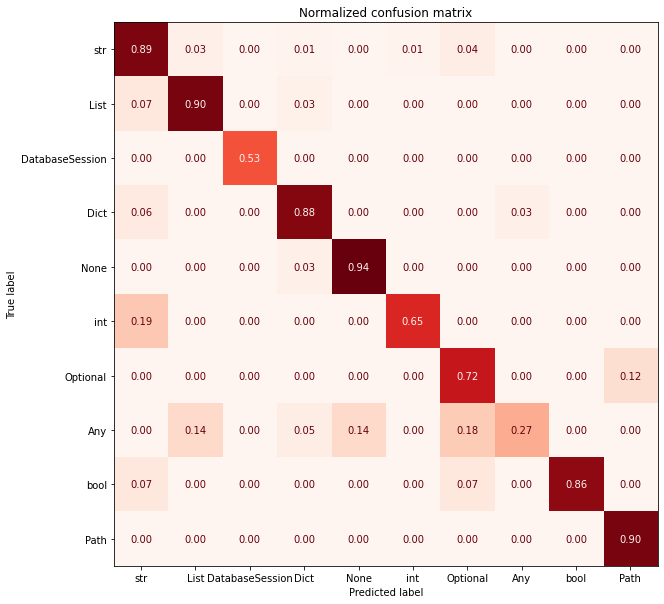

             label  accuracy  count
0              str  0.891892     74
1             List  0.900000     40
2  DatabaseSession  0.526316     38
3             Dict  0.878788     33
4             None  0.935484     31
5              int  0.653846     26
6         Optional  0.720000     25
7              Any  0.272727     22
8             bool  0.857143     14
9             Path  0.900000     10

In [17]:
from IPython.display import display_pretty

from typet5.type_env import normalize_type_name
from typet5.utils import accuracy_by_labels, confusion_matrix_top_k, display_conf_matrix

for k in ["loss"]:
    print(f"{k}:", eval_result[f"test_{k}"])
for k in ["accuracy_partial", "accuracy_full"]:
    print(f"{k}:")
    for k2, v in eval_result[f"test_{k}"].items():
        print(f"    {k2}: {v}")

pred_types = list(map(normalize_type_name, eval_result["test_pred_types"]))
label_types = list(map(normalize_type_name, eval_result["test_label_types"]))
conf_matrix = confusion_matrix_top_k(pred_types, label_types, 10)
display_conf_matrix(conf_matrix)
accs = accuracy_by_labels(pred_types, label_types, 10)
stats = []
for t, n in Counter(label_types).most_common(10):
    stats.append({"label": t, "accuracy": accs[t], "count": n})
display_pretty(pd.DataFrame(stats))


In [18]:
wandb.finish()


eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
test/loss,▁
test/n_labels,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/global_step,▁▁
eval/loss,0.46059


In [19]:
preds_for_compile_fn = Counter()
for p, l in zip(pred_types, label_types):
    l: str
    if l.strip().endswith("Union"):
        preds_for_compile_fn[p.strip()] += 1

preds_for_compile_fn.most_common()


[('str', 1), ('Union', 1)]